### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline
import tensorflow
print (tensorflow.__version__)

2.8.2


In [2]:
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "white",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "grey",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

### Load MNIST Handwritten Dataset

11501568/11490434 [==============================] - 0s 0us/step
Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


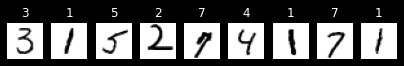

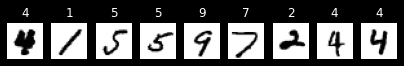

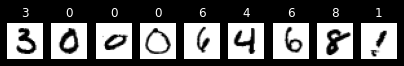

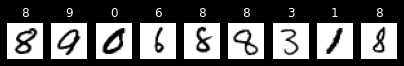

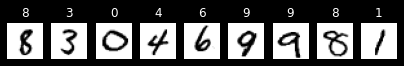

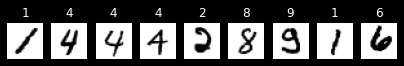

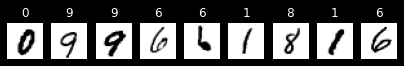

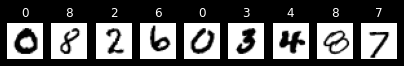

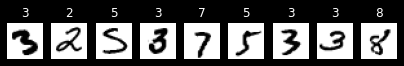

In [3]:
from tensorflow.keras.datasets import mnist

(trainX, trainY), (testX, testY) = mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))


for k in range(9):
    plt.figure(figsize=(7, 7))
    for j in range(9):
        i = np.random.randint(0, 10000)
        plt.subplot(990 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        plt.axis('off')
        plt.title(trainY[i])
    plt.show()

### Data Normalization

In [4]:
trainX = [image/255.0 for image in trainX]
testX = [image/255.0 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


### Generator Network

In [5]:
random_input = tensorflow.keras.layers.Input(shape = 50)

x = tensorflow.keras.layers.Dense(2048, activation='relu')(random_input)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
x = tensorflow.keras.layers.Dense(1024, activation='relu')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
x = tensorflow.keras.layers.Dense(28*28)(x)
x = tensorflow.keras.layers.Reshape((28, 28, 1))(x)

generated_image = tensorflow.keras.layers.Activation('sigmoid')(x)

generator_network = tensorflow.keras.models.Model(inputs=random_input, outputs=generated_image)
generator_network.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense (Dense)               (None, 2048)              104448    
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 784)               803600

### Discriminator Network

In [6]:
image_input = tensorflow.keras.layers.Input(shape=(28, 28, 1))

x = tensorflow.keras.layers.Flatten()(image_input)
x = tensorflow.keras.layers.Dense(256, activation='relu')(x)
x = tensorflow.keras.layers.Dropout(0.3)(x)
x = tensorflow.keras.layers.Dense(128, activation='relu')(x)
x = tensorflow.keras.layers.Dropout(0.5)(x)
x = tensorflow.keras.layers.Dense(1)(x)

real_vs_fake_output = tensorflow.keras.layers.Activation('sigmoid')(x)

discriminator_network = tensorflow.keras.models.Model(inputs=image_input, outputs=real_vs_fake_output)
discriminator_network.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129 

In [7]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)
discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

### The GAN Model (Combined)

In [8]:
discriminator_network.trainable=False

g_output = generator_network(random_input)
d_output = discriminator_network(g_output)

gan_model = tensorflow.keras.models.Model(random_input, d_output)
gan_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 model (Functional)          (None, 28, 28, 1)         3018512   
                                                                 
 model_1 (Functional)        (None, 1)                 233985    
                                                                 
Total params: 3,252,497
Trainable params: 3,012,368
Non-trainable params: 240,129
_________________________________________________________________


In [11]:
gan_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer)

### Data Generator

In [12]:
indices = [i for i in range(len(trainX))]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batch = np.reshape(random_values, (batch_size, noise_size))
    return random_noise_batch

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batch = get_random_noise(batch_size, noise_size) 
    fake_samples = generator_network.predict_on_batch(random_noise_batch)
    return fake_samples

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = trainX[np.array(random_indices),:]
    return real_images

def show_generator_results(generator_network):
    for k in range(9):
        plt.figure(figsize=(7, 7))
        fake_samples = get_fake_samples(generator_network, 9, noise_size)
        for j in range(9):
            plt.subplot(990 + 1 + j)
            plt.imshow(fake_samples[j,:,:,-1], cmap='gray_r')
            plt.axis('off')
            #plt.title(trainY[i])
        plt.show()
    return

### Train the GAN Model

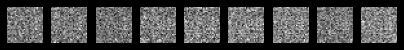

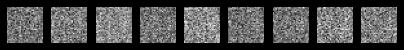

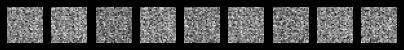

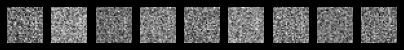

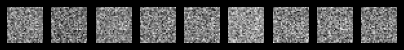

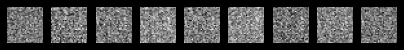

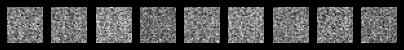

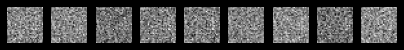

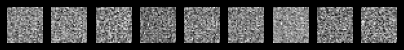

Epoch:0, Step:0, D-Loss:0.607, D-Acc:62.000, G-Loss:1.076
Epoch:0, Step:50, D-Loss:0.156, D-Acc:100.000, G-Loss:3.627
Epoch:0, Step:100, D-Loss:0.060, D-Acc:100.000, G-Loss:5.386
Epoch:0, Step:150, D-Loss:0.019, D-Acc:100.000, G-Loss:7.551
Epoch:0, Step:200, D-Loss:0.015, D-Acc:100.000, G-Loss:9.236
Epoch:0, Step:250, D-Loss:0.015, D-Acc:100.000, G-Loss:12.809
Epoch:0, Step:300, D-Loss:0.117, D-Acc:96.000, G-Loss:13.946
Epoch:0, Step:350, D-Loss:0.048, D-Acc:99.000, G-Loss:14.693
Epoch:0, Step:400, D-Loss:0.121, D-Acc:99.000, G-Loss:14.643
Epoch:0, Step:450, D-Loss:0.153, D-Acc:94.000, G-Loss:13.538
Epoch:1, Step:0, D-Loss:0.129, D-Acc:98.000, G-Loss:11.597
Epoch:1, Step:50, D-Loss:0.160, D-Acc:93.000, G-Loss:12.778
Epoch:1, Step:100, D-Loss:0.146, D-Acc:95.000, G-Loss:12.661
Epoch:1, Step:150, D-Loss:0.163, D-Acc:97.000, G-Loss:13.119
Epoch:1, Step:200, D-Loss:0.131, D-Acc:97.000, G-Loss:13.810
Epoch:1, Step:250, D-Loss:0.186, D-Acc:92.000, G-Loss:12.697
Epoch:1, Step:300, D-Loss:0.11

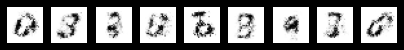

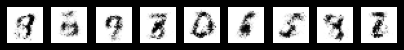

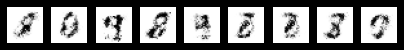

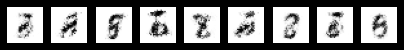

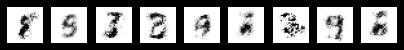

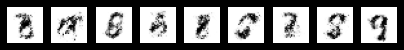

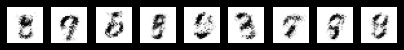

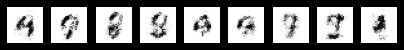

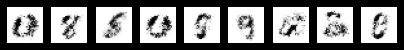

Epoch:10, Step:0, D-Loss:0.361, D-Acc:82.000, G-Loss:2.071
Epoch:10, Step:50, D-Loss:0.270, D-Acc:91.000, G-Loss:2.110
Epoch:10, Step:100, D-Loss:0.390, D-Acc:81.000, G-Loss:2.067
Epoch:10, Step:150, D-Loss:0.353, D-Acc:87.000, G-Loss:2.038
Epoch:10, Step:200, D-Loss:0.362, D-Acc:84.000, G-Loss:1.968
Epoch:10, Step:250, D-Loss:0.369, D-Acc:86.000, G-Loss:1.656
Epoch:10, Step:300, D-Loss:0.315, D-Acc:88.000, G-Loss:1.863
Epoch:10, Step:350, D-Loss:0.289, D-Acc:91.000, G-Loss:1.822
Epoch:10, Step:400, D-Loss:0.380, D-Acc:79.000, G-Loss:1.867
Epoch:10, Step:450, D-Loss:0.419, D-Acc:83.000, G-Loss:1.779
Epoch:11, Step:0, D-Loss:0.291, D-Acc:87.000, G-Loss:1.782
Epoch:11, Step:50, D-Loss:0.305, D-Acc:88.000, G-Loss:1.926
Epoch:11, Step:100, D-Loss:0.325, D-Acc:90.000, G-Loss:1.823
Epoch:11, Step:150, D-Loss:0.299, D-Acc:87.000, G-Loss:1.806
Epoch:11, Step:200, D-Loss:0.402, D-Acc:82.000, G-Loss:1.876
Epoch:11, Step:250, D-Loss:0.361, D-Acc:87.000, G-Loss:1.881
Epoch:11, Step:300, D-Loss:0.3

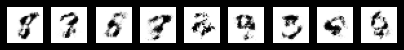

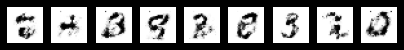

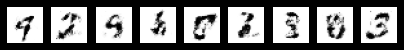

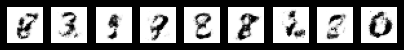

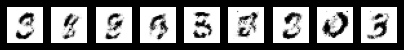

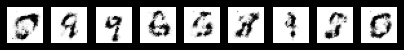

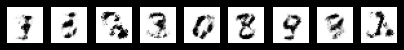

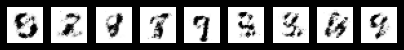

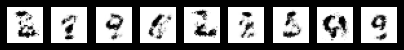

Epoch:20, Step:0, D-Loss:0.413, D-Acc:80.000, G-Loss:1.445
Epoch:20, Step:50, D-Loss:0.385, D-Acc:86.000, G-Loss:1.449
Epoch:20, Step:100, D-Loss:0.420, D-Acc:76.000, G-Loss:1.505
Epoch:20, Step:150, D-Loss:0.440, D-Acc:78.000, G-Loss:1.541
Epoch:20, Step:200, D-Loss:0.440, D-Acc:80.000, G-Loss:1.659
Epoch:20, Step:250, D-Loss:0.431, D-Acc:79.000, G-Loss:1.512
Epoch:20, Step:300, D-Loss:0.378, D-Acc:83.000, G-Loss:1.492
Epoch:20, Step:350, D-Loss:0.515, D-Acc:71.000, G-Loss:1.548
Epoch:20, Step:400, D-Loss:0.456, D-Acc:79.000, G-Loss:1.770
Epoch:20, Step:450, D-Loss:0.437, D-Acc:82.000, G-Loss:1.553
Epoch:21, Step:0, D-Loss:0.433, D-Acc:82.000, G-Loss:1.576
Epoch:21, Step:50, D-Loss:0.395, D-Acc:81.000, G-Loss:1.473
Epoch:21, Step:100, D-Loss:0.499, D-Acc:80.000, G-Loss:1.475
Epoch:21, Step:150, D-Loss:0.532, D-Acc:74.000, G-Loss:1.590
Epoch:21, Step:200, D-Loss:0.393, D-Acc:80.000, G-Loss:1.604
Epoch:21, Step:250, D-Loss:0.456, D-Acc:76.000, G-Loss:1.545
Epoch:21, Step:300, D-Loss:0.4

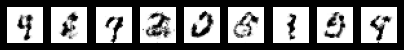

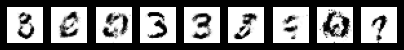

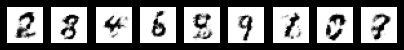

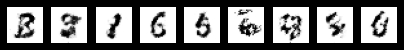

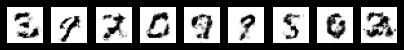

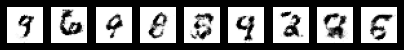

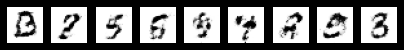

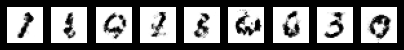

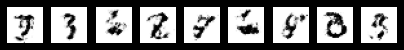

Epoch:30, Step:0, D-Loss:0.429, D-Acc:79.000, G-Loss:1.198
Epoch:30, Step:50, D-Loss:0.543, D-Acc:75.000, G-Loss:1.330
Epoch:30, Step:100, D-Loss:0.453, D-Acc:80.000, G-Loss:1.243
Epoch:30, Step:150, D-Loss:0.492, D-Acc:75.000, G-Loss:1.429
Epoch:30, Step:200, D-Loss:0.482, D-Acc:78.000, G-Loss:1.362
Epoch:30, Step:250, D-Loss:0.579, D-Acc:70.000, G-Loss:1.253
Epoch:30, Step:300, D-Loss:0.433, D-Acc:78.000, G-Loss:1.249
Epoch:30, Step:350, D-Loss:0.554, D-Acc:77.000, G-Loss:1.318
Epoch:30, Step:400, D-Loss:0.619, D-Acc:68.000, G-Loss:1.401
Epoch:30, Step:450, D-Loss:0.589, D-Acc:65.000, G-Loss:1.244
Epoch:31, Step:0, D-Loss:0.621, D-Acc:68.000, G-Loss:1.276
Epoch:31, Step:50, D-Loss:0.456, D-Acc:76.000, G-Loss:1.186
Epoch:31, Step:100, D-Loss:0.481, D-Acc:75.000, G-Loss:1.341
Epoch:31, Step:150, D-Loss:0.520, D-Acc:73.000, G-Loss:1.267
Epoch:31, Step:200, D-Loss:0.415, D-Acc:80.000, G-Loss:1.269
Epoch:31, Step:250, D-Loss:0.585, D-Acc:67.000, G-Loss:1.256
Epoch:31, Step:300, D-Loss:0.5

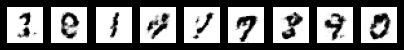

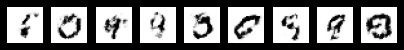

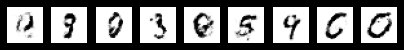

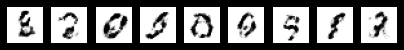

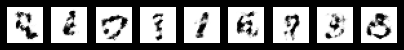

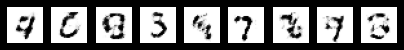

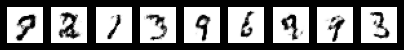

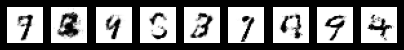

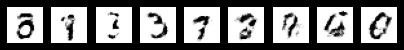

Epoch:40, Step:0, D-Loss:0.593, D-Acc:66.000, G-Loss:1.068
Epoch:40, Step:50, D-Loss:0.595, D-Acc:67.000, G-Loss:1.190
Epoch:40, Step:100, D-Loss:0.606, D-Acc:66.000, G-Loss:1.180
Epoch:40, Step:150, D-Loss:0.538, D-Acc:72.000, G-Loss:1.167
Epoch:40, Step:200, D-Loss:0.489, D-Acc:81.000, G-Loss:1.012
Epoch:40, Step:250, D-Loss:0.551, D-Acc:71.000, G-Loss:1.102
Epoch:40, Step:300, D-Loss:0.523, D-Acc:73.000, G-Loss:1.120
Epoch:40, Step:350, D-Loss:0.674, D-Acc:63.000, G-Loss:1.062
Epoch:40, Step:400, D-Loss:0.506, D-Acc:73.000, G-Loss:1.126
Epoch:40, Step:450, D-Loss:0.477, D-Acc:82.000, G-Loss:1.048
Epoch:41, Step:0, D-Loss:0.583, D-Acc:68.000, G-Loss:1.151
Epoch:41, Step:50, D-Loss:0.539, D-Acc:71.000, G-Loss:1.112
Epoch:41, Step:100, D-Loss:0.585, D-Acc:71.000, G-Loss:1.050
Epoch:41, Step:150, D-Loss:0.651, D-Acc:58.000, G-Loss:1.123
Epoch:41, Step:200, D-Loss:0.518, D-Acc:74.000, G-Loss:1.105
Epoch:41, Step:250, D-Loss:0.535, D-Acc:80.000, G-Loss:1.170
Epoch:41, Step:300, D-Loss:0.5

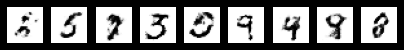

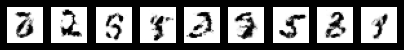

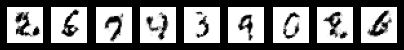

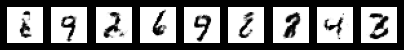

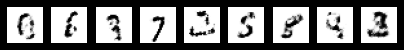

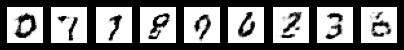

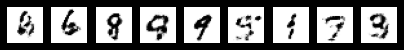

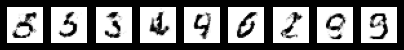

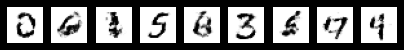

Epoch:50, Step:0, D-Loss:0.523, D-Acc:77.000, G-Loss:0.959
Epoch:50, Step:50, D-Loss:0.639, D-Acc:62.000, G-Loss:0.994
Epoch:50, Step:100, D-Loss:0.529, D-Acc:75.000, G-Loss:1.052
Epoch:50, Step:150, D-Loss:0.484, D-Acc:79.000, G-Loss:1.015
Epoch:50, Step:200, D-Loss:0.547, D-Acc:71.000, G-Loss:1.012
Epoch:50, Step:250, D-Loss:0.597, D-Acc:65.000, G-Loss:1.009
Epoch:50, Step:300, D-Loss:0.575, D-Acc:67.000, G-Loss:1.080
Epoch:50, Step:350, D-Loss:0.573, D-Acc:73.000, G-Loss:0.933
Epoch:50, Step:400, D-Loss:0.613, D-Acc:71.000, G-Loss:0.978
Epoch:50, Step:450, D-Loss:0.520, D-Acc:70.000, G-Loss:0.988
Epoch:51, Step:0, D-Loss:0.634, D-Acc:61.000, G-Loss:1.011
Epoch:51, Step:50, D-Loss:0.546, D-Acc:73.000, G-Loss:0.996
Epoch:51, Step:100, D-Loss:0.551, D-Acc:69.000, G-Loss:1.040
Epoch:51, Step:150, D-Loss:0.610, D-Acc:67.000, G-Loss:0.958
Epoch:51, Step:200, D-Loss:0.618, D-Acc:65.000, G-Loss:0.949
Epoch:51, Step:250, D-Loss:0.578, D-Acc:68.000, G-Loss:0.933
Epoch:51, Step:300, D-Loss:0.5

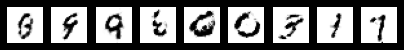

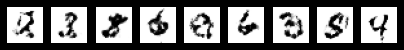

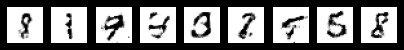

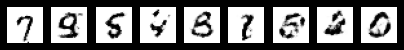

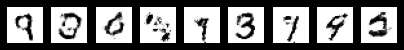

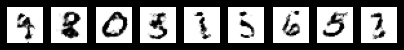

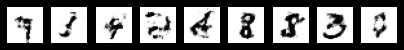

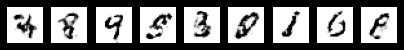

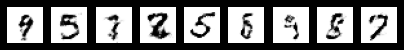

Epoch:60, Step:0, D-Loss:0.617, D-Acc:68.000, G-Loss:0.941
Epoch:60, Step:50, D-Loss:0.657, D-Acc:57.000, G-Loss:0.965
Epoch:60, Step:100, D-Loss:0.697, D-Acc:57.000, G-Loss:0.973
Epoch:60, Step:150, D-Loss:0.560, D-Acc:74.000, G-Loss:0.957
Epoch:60, Step:200, D-Loss:0.544, D-Acc:69.000, G-Loss:0.960
Epoch:60, Step:250, D-Loss:0.670, D-Acc:61.000, G-Loss:0.974
Epoch:60, Step:300, D-Loss:0.607, D-Acc:61.000, G-Loss:0.942
Epoch:60, Step:350, D-Loss:0.581, D-Acc:64.000, G-Loss:0.967
Epoch:60, Step:400, D-Loss:0.628, D-Acc:68.000, G-Loss:0.924
Epoch:60, Step:450, D-Loss:0.657, D-Acc:66.000, G-Loss:1.047
Epoch:61, Step:0, D-Loss:0.597, D-Acc:69.000, G-Loss:0.933
Epoch:61, Step:50, D-Loss:0.602, D-Acc:69.000, G-Loss:0.906
Epoch:61, Step:100, D-Loss:0.637, D-Acc:60.000, G-Loss:0.948
Epoch:61, Step:150, D-Loss:0.556, D-Acc:73.000, G-Loss:0.943
Epoch:61, Step:200, D-Loss:0.616, D-Acc:65.000, G-Loss:0.906
Epoch:61, Step:250, D-Loss:0.504, D-Acc:82.000, G-Loss:0.939
Epoch:61, Step:300, D-Loss:0.6

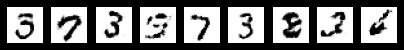

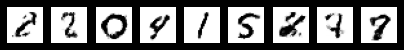

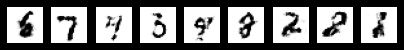

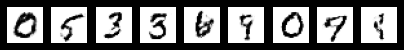

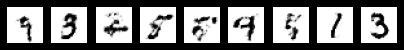

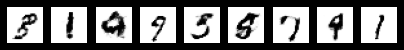

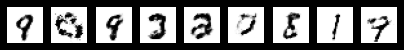

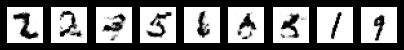

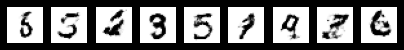

Epoch:70, Step:0, D-Loss:0.577, D-Acc:74.000, G-Loss:0.991
Epoch:70, Step:50, D-Loss:0.660, D-Acc:65.000, G-Loss:0.983
Epoch:70, Step:100, D-Loss:0.575, D-Acc:72.000, G-Loss:0.911
Epoch:70, Step:150, D-Loss:0.571, D-Acc:71.000, G-Loss:0.962
Epoch:70, Step:200, D-Loss:0.592, D-Acc:71.000, G-Loss:0.924
Epoch:70, Step:250, D-Loss:0.616, D-Acc:73.000, G-Loss:0.886
Epoch:70, Step:300, D-Loss:0.584, D-Acc:70.000, G-Loss:1.024
Epoch:70, Step:350, D-Loss:0.654, D-Acc:64.000, G-Loss:0.988
Epoch:70, Step:400, D-Loss:0.605, D-Acc:66.000, G-Loss:0.938
Epoch:70, Step:450, D-Loss:0.575, D-Acc:74.000, G-Loss:0.945
Epoch:71, Step:0, D-Loss:0.605, D-Acc:68.000, G-Loss:0.925
Epoch:71, Step:50, D-Loss:0.591, D-Acc:64.000, G-Loss:0.906
Epoch:71, Step:100, D-Loss:0.690, D-Acc:53.000, G-Loss:0.911
Epoch:71, Step:150, D-Loss:0.577, D-Acc:67.000, G-Loss:0.977
Epoch:71, Step:200, D-Loss:0.520, D-Acc:76.000, G-Loss:1.000
Epoch:71, Step:250, D-Loss:0.617, D-Acc:66.000, G-Loss:0.923
Epoch:71, Step:300, D-Loss:0.5

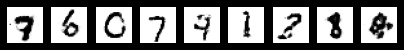

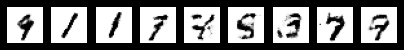

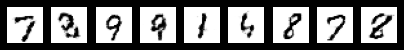

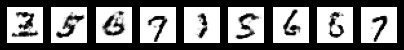

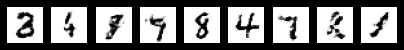

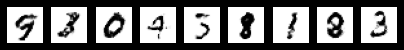

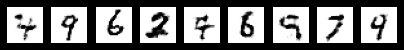

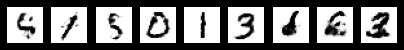

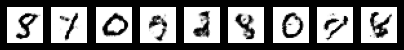

Epoch:80, Step:0, D-Loss:0.613, D-Acc:69.000, G-Loss:0.898
Epoch:80, Step:50, D-Loss:0.667, D-Acc:60.000, G-Loss:0.957
Epoch:80, Step:100, D-Loss:0.593, D-Acc:68.000, G-Loss:0.949
Epoch:80, Step:150, D-Loss:0.610, D-Acc:72.000, G-Loss:0.849
Epoch:80, Step:200, D-Loss:0.581, D-Acc:73.000, G-Loss:0.862
Epoch:80, Step:250, D-Loss:0.561, D-Acc:74.000, G-Loss:0.930
Epoch:80, Step:300, D-Loss:0.656, D-Acc:59.000, G-Loss:0.968
Epoch:80, Step:350, D-Loss:0.653, D-Acc:63.000, G-Loss:0.923
Epoch:80, Step:400, D-Loss:0.540, D-Acc:75.000, G-Loss:0.952
Epoch:80, Step:450, D-Loss:0.605, D-Acc:67.000, G-Loss:0.939
Epoch:81, Step:0, D-Loss:0.612, D-Acc:65.000, G-Loss:0.879
Epoch:81, Step:50, D-Loss:0.662, D-Acc:59.000, G-Loss:0.917
Epoch:81, Step:100, D-Loss:0.591, D-Acc:67.000, G-Loss:0.924
Epoch:81, Step:150, D-Loss:0.619, D-Acc:67.000, G-Loss:0.911
Epoch:81, Step:200, D-Loss:0.591, D-Acc:67.000, G-Loss:0.939
Epoch:81, Step:250, D-Loss:0.723, D-Acc:57.000, G-Loss:0.911
Epoch:81, Step:300, D-Loss:0.6

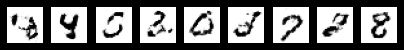

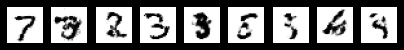

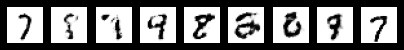

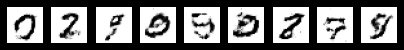

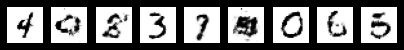

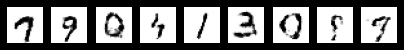

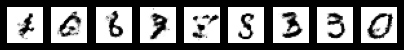

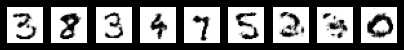

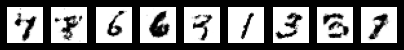

Epoch:90, Step:0, D-Loss:0.604, D-Acc:69.000, G-Loss:0.896
Epoch:90, Step:50, D-Loss:0.620, D-Acc:66.000, G-Loss:0.970
Epoch:90, Step:100, D-Loss:0.651, D-Acc:58.000, G-Loss:0.963
Epoch:90, Step:150, D-Loss:0.558, D-Acc:75.000, G-Loss:0.944
Epoch:90, Step:200, D-Loss:0.618, D-Acc:60.000, G-Loss:1.016
Epoch:90, Step:250, D-Loss:0.619, D-Acc:65.000, G-Loss:0.838
Epoch:90, Step:300, D-Loss:0.669, D-Acc:63.000, G-Loss:0.933
Epoch:90, Step:350, D-Loss:0.627, D-Acc:65.000, G-Loss:0.844
Epoch:90, Step:400, D-Loss:0.674, D-Acc:59.000, G-Loss:0.810
Epoch:90, Step:450, D-Loss:0.617, D-Acc:66.000, G-Loss:0.896
Epoch:91, Step:0, D-Loss:0.564, D-Acc:68.000, G-Loss:0.913
Epoch:91, Step:50, D-Loss:0.547, D-Acc:72.000, G-Loss:0.917
Epoch:91, Step:100, D-Loss:0.696, D-Acc:60.000, G-Loss:0.923
Epoch:91, Step:150, D-Loss:0.618, D-Acc:64.000, G-Loss:0.910
Epoch:91, Step:200, D-Loss:0.557, D-Acc:75.000, G-Loss:0.890
Epoch:91, Step:250, D-Loss:0.655, D-Acc:58.000, G-Loss:0.888
Epoch:91, Step:300, D-Loss:0.6

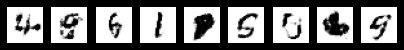

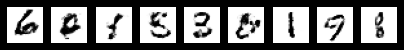

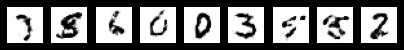

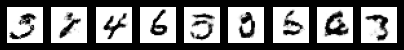

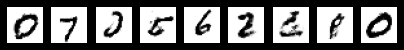

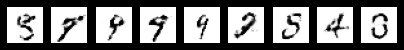

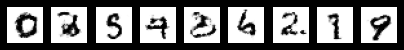

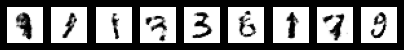

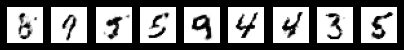

Epoch:100, Step:0, D-Loss:0.606, D-Acc:64.000, G-Loss:0.936
Epoch:100, Step:50, D-Loss:0.590, D-Acc:71.000, G-Loss:0.888
Epoch:100, Step:100, D-Loss:0.552, D-Acc:72.000, G-Loss:0.975
Epoch:100, Step:150, D-Loss:0.650, D-Acc:64.000, G-Loss:0.980
Epoch:100, Step:200, D-Loss:0.632, D-Acc:59.000, G-Loss:0.914
Epoch:100, Step:250, D-Loss:0.564, D-Acc:72.000, G-Loss:0.924
Epoch:100, Step:300, D-Loss:0.560, D-Acc:71.000, G-Loss:0.913
Epoch:100, Step:350, D-Loss:0.646, D-Acc:61.000, G-Loss:0.886
Epoch:100, Step:400, D-Loss:0.639, D-Acc:56.000, G-Loss:0.871
Epoch:100, Step:450, D-Loss:0.574, D-Acc:70.000, G-Loss:0.907
Epoch:101, Step:0, D-Loss:0.654, D-Acc:58.000, G-Loss:0.946
Epoch:101, Step:50, D-Loss:0.675, D-Acc:56.000, G-Loss:0.890
Epoch:101, Step:100, D-Loss:0.587, D-Acc:70.000, G-Loss:0.855
Epoch:101, Step:150, D-Loss:0.625, D-Acc:65.000, G-Loss:0.910
Epoch:101, Step:200, D-Loss:0.676, D-Acc:58.000, G-Loss:0.882
Epoch:101, Step:250, D-Loss:0.621, D-Acc:67.000, G-Loss:0.942
Epoch:101, Ste

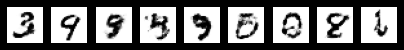

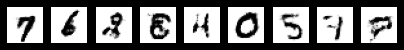

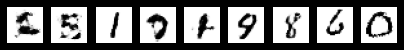

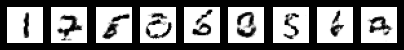

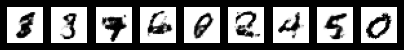

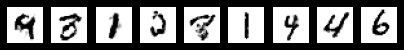

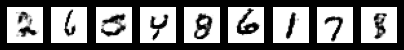

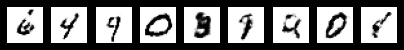

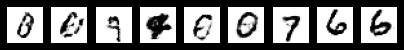

Epoch:110, Step:0, D-Loss:0.629, D-Acc:63.000, G-Loss:1.002
Epoch:110, Step:50, D-Loss:0.574, D-Acc:74.000, G-Loss:0.993
Epoch:110, Step:100, D-Loss:0.592, D-Acc:72.000, G-Loss:0.935
Epoch:110, Step:150, D-Loss:0.599, D-Acc:67.000, G-Loss:0.991
Epoch:110, Step:200, D-Loss:0.576, D-Acc:70.000, G-Loss:0.938
Epoch:110, Step:250, D-Loss:0.604, D-Acc:67.000, G-Loss:0.897
Epoch:110, Step:300, D-Loss:0.636, D-Acc:68.000, G-Loss:0.979
Epoch:110, Step:350, D-Loss:0.543, D-Acc:72.000, G-Loss:1.017
Epoch:110, Step:400, D-Loss:0.591, D-Acc:68.000, G-Loss:0.941
Epoch:110, Step:450, D-Loss:0.539, D-Acc:72.000, G-Loss:0.938
Epoch:111, Step:0, D-Loss:0.590, D-Acc:66.000, G-Loss:0.953
Epoch:111, Step:50, D-Loss:0.579, D-Acc:73.000, G-Loss:0.981
Epoch:111, Step:100, D-Loss:0.633, D-Acc:59.000, G-Loss:0.847
Epoch:111, Step:150, D-Loss:0.652, D-Acc:60.000, G-Loss:0.974
Epoch:111, Step:200, D-Loss:0.575, D-Acc:70.000, G-Loss:1.027
Epoch:111, Step:250, D-Loss:0.650, D-Acc:67.000, G-Loss:0.945
Epoch:111, Ste

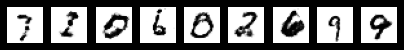

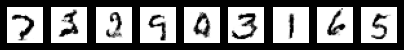

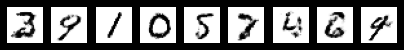

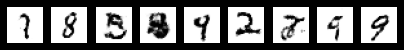

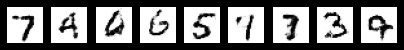

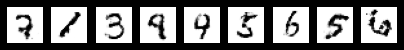

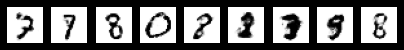

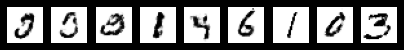

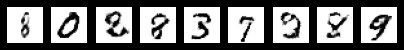

Epoch:120, Step:0, D-Loss:0.624, D-Acc:64.000, G-Loss:0.964
Epoch:120, Step:50, D-Loss:0.599, D-Acc:64.000, G-Loss:1.040
Epoch:120, Step:100, D-Loss:0.538, D-Acc:72.000, G-Loss:0.934
Epoch:120, Step:150, D-Loss:0.583, D-Acc:64.000, G-Loss:0.977
Epoch:120, Step:200, D-Loss:0.626, D-Acc:66.000, G-Loss:1.015
Epoch:120, Step:250, D-Loss:0.578, D-Acc:70.000, G-Loss:0.931
Epoch:120, Step:300, D-Loss:0.554, D-Acc:73.000, G-Loss:0.907
Epoch:120, Step:350, D-Loss:0.568, D-Acc:71.000, G-Loss:0.951
Epoch:120, Step:400, D-Loss:0.596, D-Acc:68.000, G-Loss:0.970
Epoch:120, Step:450, D-Loss:0.627, D-Acc:64.000, G-Loss:0.926
Epoch:121, Step:0, D-Loss:0.628, D-Acc:67.000, G-Loss:0.955
Epoch:121, Step:50, D-Loss:0.594, D-Acc:64.000, G-Loss:0.989
Epoch:121, Step:100, D-Loss:0.635, D-Acc:67.000, G-Loss:0.962
Epoch:121, Step:150, D-Loss:0.561, D-Acc:71.000, G-Loss:0.988
Epoch:121, Step:200, D-Loss:0.621, D-Acc:62.000, G-Loss:0.910
Epoch:121, Step:250, D-Loss:0.582, D-Acc:73.000, G-Loss:0.904
Epoch:121, Ste

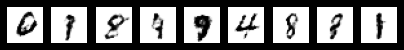

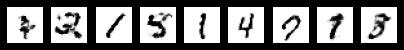

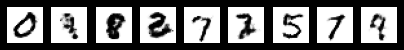

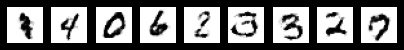

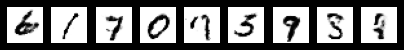

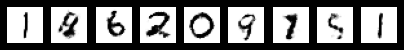

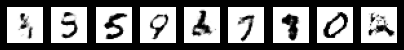

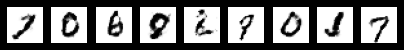

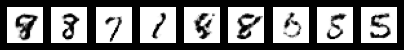

Epoch:130, Step:0, D-Loss:0.515, D-Acc:72.000, G-Loss:0.945
Epoch:130, Step:50, D-Loss:0.600, D-Acc:68.000, G-Loss:1.049
Epoch:130, Step:100, D-Loss:0.590, D-Acc:72.000, G-Loss:0.966
Epoch:130, Step:150, D-Loss:0.601, D-Acc:64.000, G-Loss:0.948
Epoch:130, Step:200, D-Loss:0.592, D-Acc:69.000, G-Loss:1.062
Epoch:130, Step:250, D-Loss:0.562, D-Acc:69.000, G-Loss:0.888
Epoch:130, Step:300, D-Loss:0.635, D-Acc:62.000, G-Loss:0.977
Epoch:130, Step:350, D-Loss:0.663, D-Acc:57.000, G-Loss:0.939
Epoch:130, Step:400, D-Loss:0.637, D-Acc:63.000, G-Loss:1.060
Epoch:130, Step:450, D-Loss:0.637, D-Acc:61.000, G-Loss:0.922
Epoch:131, Step:0, D-Loss:0.626, D-Acc:63.000, G-Loss:0.963
Epoch:131, Step:50, D-Loss:0.564, D-Acc:67.000, G-Loss:1.024
Epoch:131, Step:100, D-Loss:0.547, D-Acc:72.000, G-Loss:0.901
Epoch:131, Step:150, D-Loss:0.587, D-Acc:68.000, G-Loss:0.990
Epoch:131, Step:200, D-Loss:0.605, D-Acc:67.000, G-Loss:0.956
Epoch:131, Step:250, D-Loss:0.640, D-Acc:63.000, G-Loss:0.973
Epoch:131, Ste

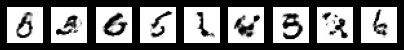

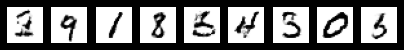

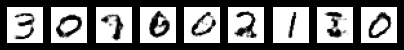

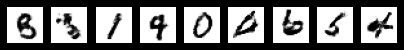

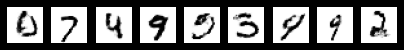

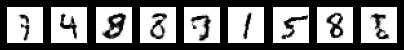

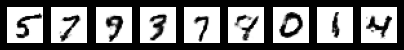

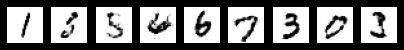

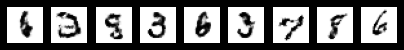

Epoch:140, Step:0, D-Loss:0.608, D-Acc:60.000, G-Loss:0.987
Epoch:140, Step:50, D-Loss:0.598, D-Acc:65.000, G-Loss:1.069
Epoch:140, Step:100, D-Loss:0.648, D-Acc:61.000, G-Loss:1.008
Epoch:140, Step:150, D-Loss:0.658, D-Acc:66.000, G-Loss:1.000
Epoch:140, Step:200, D-Loss:0.580, D-Acc:69.000, G-Loss:1.026
Epoch:140, Step:250, D-Loss:0.622, D-Acc:58.000, G-Loss:1.006
Epoch:140, Step:300, D-Loss:0.586, D-Acc:66.000, G-Loss:0.989
Epoch:140, Step:350, D-Loss:0.603, D-Acc:64.000, G-Loss:0.952
Epoch:140, Step:400, D-Loss:0.604, D-Acc:67.000, G-Loss:0.981
Epoch:140, Step:450, D-Loss:0.534, D-Acc:74.000, G-Loss:1.007
Epoch:141, Step:0, D-Loss:0.629, D-Acc:65.000, G-Loss:0.987
Epoch:141, Step:50, D-Loss:0.607, D-Acc:67.000, G-Loss:1.060
Epoch:141, Step:100, D-Loss:0.559, D-Acc:77.000, G-Loss:1.009
Epoch:141, Step:150, D-Loss:0.640, D-Acc:64.000, G-Loss:0.876
Epoch:141, Step:200, D-Loss:0.546, D-Acc:73.000, G-Loss:0.946
Epoch:141, Step:250, D-Loss:0.626, D-Acc:63.000, G-Loss:0.993
Epoch:141, Ste

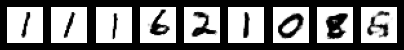

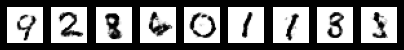

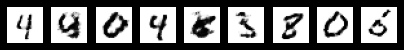

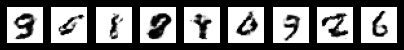

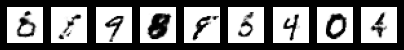

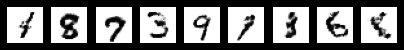

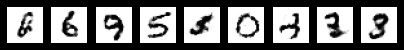

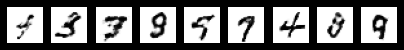

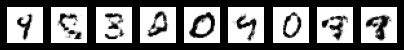

Epoch:150, Step:0, D-Loss:0.606, D-Acc:66.000, G-Loss:0.998
Epoch:150, Step:50, D-Loss:0.643, D-Acc:64.000, G-Loss:1.088
Epoch:150, Step:100, D-Loss:0.584, D-Acc:71.000, G-Loss:1.015
Epoch:150, Step:150, D-Loss:0.571, D-Acc:72.000, G-Loss:1.092
Epoch:150, Step:200, D-Loss:0.566, D-Acc:65.000, G-Loss:1.120
Epoch:150, Step:250, D-Loss:0.570, D-Acc:73.000, G-Loss:0.964
Epoch:150, Step:300, D-Loss:0.598, D-Acc:69.000, G-Loss:0.970
Epoch:150, Step:350, D-Loss:0.602, D-Acc:65.000, G-Loss:1.018
Epoch:150, Step:400, D-Loss:0.592, D-Acc:67.000, G-Loss:0.979
Epoch:150, Step:450, D-Loss:0.673, D-Acc:57.000, G-Loss:1.023
Epoch:151, Step:0, D-Loss:0.558, D-Acc:70.000, G-Loss:0.983
Epoch:151, Step:50, D-Loss:0.583, D-Acc:71.000, G-Loss:0.950
Epoch:151, Step:100, D-Loss:0.571, D-Acc:67.000, G-Loss:0.982
Epoch:151, Step:150, D-Loss:0.630, D-Acc:64.000, G-Loss:0.936
Epoch:151, Step:200, D-Loss:0.555, D-Acc:68.000, G-Loss:1.068
Epoch:151, Step:250, D-Loss:0.507, D-Acc:80.000, G-Loss:1.045
Epoch:151, Ste

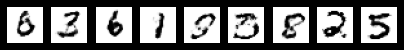

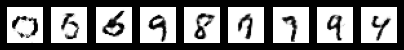

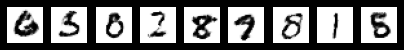

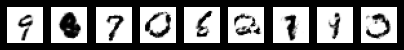

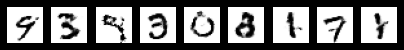

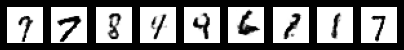

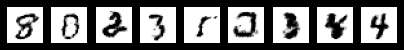

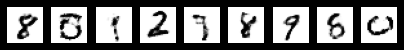

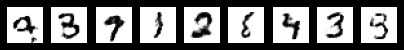

Epoch:160, Step:0, D-Loss:0.572, D-Acc:64.000, G-Loss:1.120
Epoch:160, Step:50, D-Loss:0.595, D-Acc:65.000, G-Loss:0.872
Epoch:160, Step:100, D-Loss:0.496, D-Acc:75.000, G-Loss:1.008
Epoch:160, Step:150, D-Loss:0.609, D-Acc:64.000, G-Loss:1.137
Epoch:160, Step:200, D-Loss:0.596, D-Acc:69.000, G-Loss:0.947
Epoch:160, Step:250, D-Loss:0.578, D-Acc:73.000, G-Loss:0.978
Epoch:160, Step:300, D-Loss:0.589, D-Acc:66.000, G-Loss:0.978
Epoch:160, Step:350, D-Loss:0.516, D-Acc:78.000, G-Loss:1.046
Epoch:160, Step:400, D-Loss:0.607, D-Acc:68.000, G-Loss:1.007
Epoch:160, Step:450, D-Loss:0.542, D-Acc:71.000, G-Loss:0.917
Epoch:161, Step:0, D-Loss:0.557, D-Acc:75.000, G-Loss:1.020
Epoch:161, Step:50, D-Loss:0.618, D-Acc:63.000, G-Loss:0.985
Epoch:161, Step:100, D-Loss:0.601, D-Acc:69.000, G-Loss:1.035
Epoch:161, Step:150, D-Loss:0.636, D-Acc:60.000, G-Loss:1.028
Epoch:161, Step:200, D-Loss:0.633, D-Acc:64.000, G-Loss:1.050
Epoch:161, Step:250, D-Loss:0.601, D-Acc:62.000, G-Loss:1.016
Epoch:161, Ste

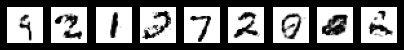

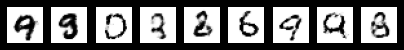

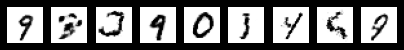

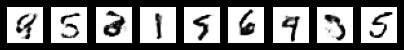

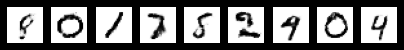

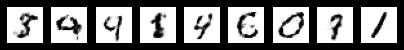

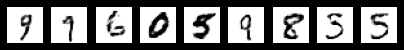

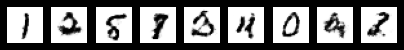

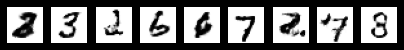

Epoch:170, Step:0, D-Loss:0.626, D-Acc:69.000, G-Loss:1.088
Epoch:170, Step:50, D-Loss:0.567, D-Acc:74.000, G-Loss:1.079
Epoch:170, Step:100, D-Loss:0.576, D-Acc:69.000, G-Loss:1.048
Epoch:170, Step:150, D-Loss:0.583, D-Acc:71.000, G-Loss:0.968
Epoch:170, Step:200, D-Loss:0.563, D-Acc:74.000, G-Loss:1.061
Epoch:170, Step:250, D-Loss:0.565, D-Acc:67.000, G-Loss:1.007
Epoch:170, Step:300, D-Loss:0.581, D-Acc:69.000, G-Loss:0.979
Epoch:170, Step:350, D-Loss:0.621, D-Acc:62.000, G-Loss:1.179
Epoch:170, Step:400, D-Loss:0.590, D-Acc:69.000, G-Loss:1.000
Epoch:170, Step:450, D-Loss:0.585, D-Acc:69.000, G-Loss:0.987
Epoch:171, Step:0, D-Loss:0.574, D-Acc:71.000, G-Loss:0.993
Epoch:171, Step:50, D-Loss:0.615, D-Acc:65.000, G-Loss:1.030
Epoch:171, Step:100, D-Loss:0.523, D-Acc:77.000, G-Loss:1.092
Epoch:171, Step:150, D-Loss:0.563, D-Acc:72.000, G-Loss:1.052
Epoch:171, Step:200, D-Loss:0.558, D-Acc:70.000, G-Loss:1.047
Epoch:171, Step:250, D-Loss:0.655, D-Acc:69.000, G-Loss:1.011
Epoch:171, Ste

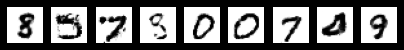

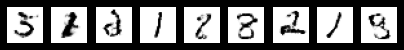

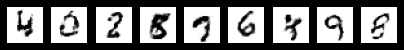

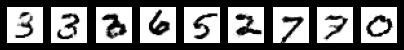

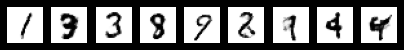

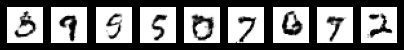

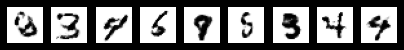

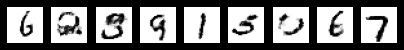

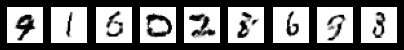

Epoch:180, Step:0, D-Loss:0.567, D-Acc:68.000, G-Loss:1.065
Epoch:180, Step:50, D-Loss:0.551, D-Acc:75.000, G-Loss:0.894
Epoch:180, Step:100, D-Loss:0.602, D-Acc:64.000, G-Loss:1.031
Epoch:180, Step:150, D-Loss:0.543, D-Acc:70.000, G-Loss:1.013
Epoch:180, Step:200, D-Loss:0.606, D-Acc:65.000, G-Loss:1.087
Epoch:180, Step:250, D-Loss:0.546, D-Acc:72.000, G-Loss:1.086
Epoch:180, Step:300, D-Loss:0.564, D-Acc:67.000, G-Loss:1.005
Epoch:180, Step:350, D-Loss:0.616, D-Acc:69.000, G-Loss:0.951
Epoch:180, Step:400, D-Loss:0.561, D-Acc:72.000, G-Loss:1.036
Epoch:180, Step:450, D-Loss:0.613, D-Acc:61.000, G-Loss:1.098
Epoch:181, Step:0, D-Loss:0.517, D-Acc:81.000, G-Loss:1.027
Epoch:181, Step:50, D-Loss:0.645, D-Acc:62.000, G-Loss:1.106
Epoch:181, Step:100, D-Loss:0.555, D-Acc:72.000, G-Loss:1.036
Epoch:181, Step:150, D-Loss:0.552, D-Acc:67.000, G-Loss:1.082
Epoch:181, Step:200, D-Loss:0.553, D-Acc:72.000, G-Loss:1.077
Epoch:181, Step:250, D-Loss:0.567, D-Acc:75.000, G-Loss:1.071
Epoch:181, Ste

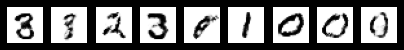

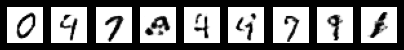

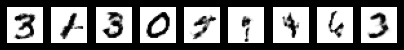

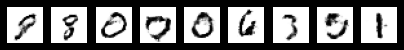

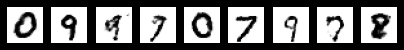

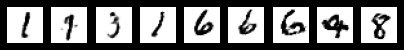

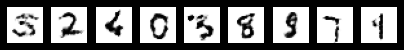

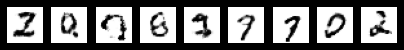

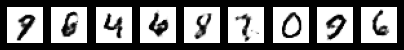

Epoch:190, Step:0, D-Loss:0.535, D-Acc:71.000, G-Loss:1.013
Epoch:190, Step:50, D-Loss:0.588, D-Acc:66.000, G-Loss:1.054
Epoch:190, Step:100, D-Loss:0.635, D-Acc:64.000, G-Loss:1.089
Epoch:190, Step:150, D-Loss:0.568, D-Acc:64.000, G-Loss:1.002
Epoch:190, Step:200, D-Loss:0.581, D-Acc:70.000, G-Loss:1.031
Epoch:190, Step:250, D-Loss:0.518, D-Acc:78.000, G-Loss:1.046
Epoch:190, Step:300, D-Loss:0.534, D-Acc:73.000, G-Loss:0.969
Epoch:190, Step:350, D-Loss:0.611, D-Acc:64.000, G-Loss:1.115
Epoch:190, Step:400, D-Loss:0.594, D-Acc:69.000, G-Loss:1.084
Epoch:190, Step:450, D-Loss:0.603, D-Acc:66.000, G-Loss:1.080
Epoch:191, Step:0, D-Loss:0.613, D-Acc:64.000, G-Loss:0.944
Epoch:191, Step:50, D-Loss:0.621, D-Acc:69.000, G-Loss:1.012
Epoch:191, Step:100, D-Loss:0.602, D-Acc:67.000, G-Loss:1.182
Epoch:191, Step:150, D-Loss:0.552, D-Acc:72.000, G-Loss:1.032
Epoch:191, Step:200, D-Loss:0.573, D-Acc:69.000, G-Loss:1.180
Epoch:191, Step:250, D-Loss:0.605, D-Acc:68.000, G-Loss:1.233
Epoch:191, Ste

In [13]:
epochs = 200
batch_size = 100
steps = 500
noise_size = 50

losses_d = []
losses_g = []

for i in range(0, epochs):
    if (i%10 == 0):
        show_generator_results(generator_network)
    for j in range(steps):
        fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size)
        real_samples = get_real_samples(batch_size=batch_size//2)

        fake_y = np.zeros((batch_size//2, 1))
        real_y = np.ones((batch_size//2, 1))
        
        input_batch = np.vstack((fake_samples, real_samples))
        output_labels = np.vstack((fake_y, real_y))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d = discriminator_network.train_on_batch(input_batch, output_labels)
        
        gan_input = get_random_noise(batch_size, noise_size)
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        gan_output = np.ones((batch_size))
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g = gan_model.train_on_batch(gan_input, gan_output)

        losses_d.append(loss_d[0])
        losses_g.append(loss_g)
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g))

### Show results

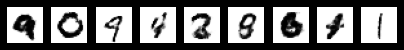

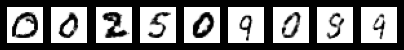

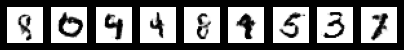

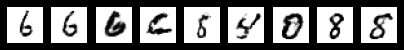

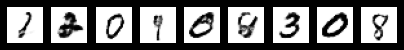

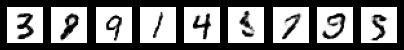

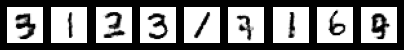

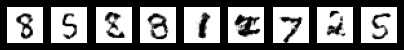

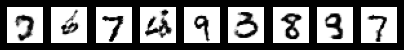

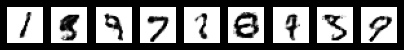

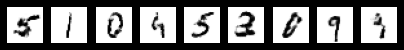

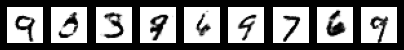

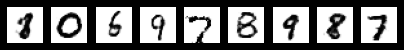

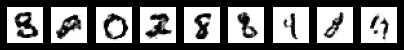

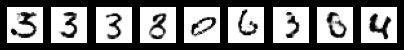

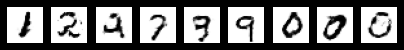

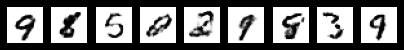

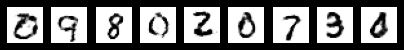

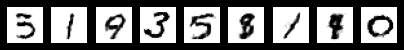

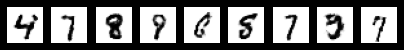

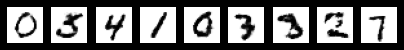

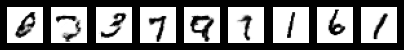

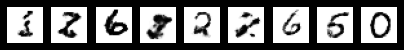

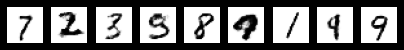

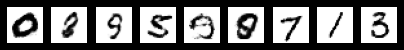

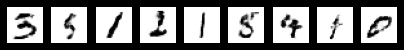

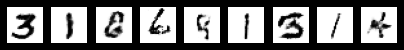

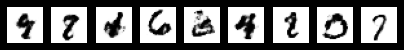

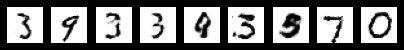

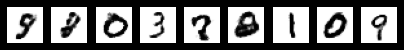

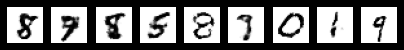

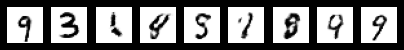

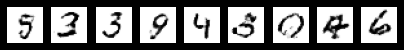

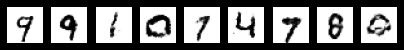

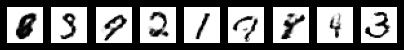

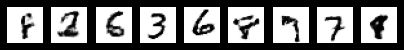

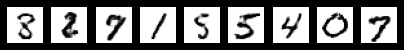

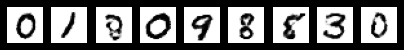

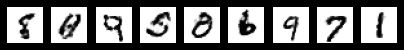

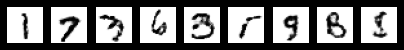

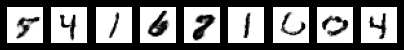

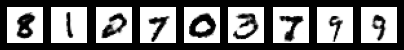

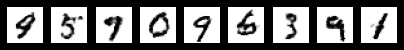

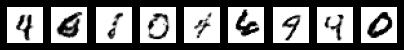

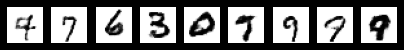

In [14]:
for i in range(5):
    show_generator_results(generator_network)

### Plot GAN Loss

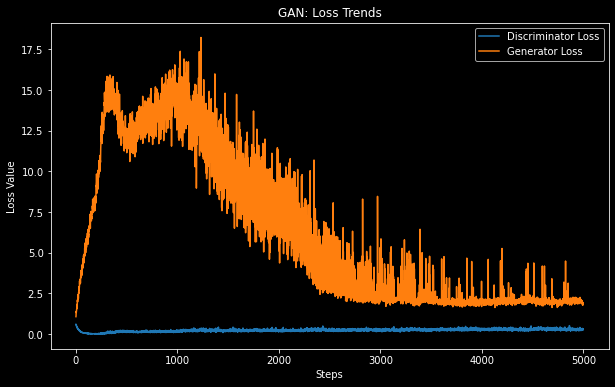

In [15]:
steps = [i for i in range(len(losses_d))]
plt.figure(figsize=(10, 6))
plt.plot(losses_d[:5000])
plt.plot(losses_g[:5000])
plt.xlabel('Steps')
plt.ylabel('Loss Value')
plt.title("GAN: Loss Trends")
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show()

---